# 0. import

In [44]:
import boto3
import pandas as pd
import io

# 1. 데이터 로드

In [45]:
# Parquet 파일 경로
save_path = './datasets/raw/rtu_data_full.csv'

# Parquet 파일을 DataFrame으로 읽기
df = pd.read_parquet(save_path)

# 읽은 데이터프레임 확인
print(df)


"""
[read_csv가 아닌 read_parquet인 이유]
파일 확장자는 .csv이지만 실제로는 Parquet 포맷이거나 다른 바이너리 포맷입니다.
혹은 CSV는 맞지만 다른 문자 인코딩 (예: latin1, cp949)으로 저장되어 있어 UTF-8로는 읽을 수 없습니다.
"""

         module(equipment)      timestamp       localtime  operation  \
0                  1(PM-3)  1733040000000  20241201000000          1   
1                  1(PM-3)  1733040005000  20241201000005          1   
2                  1(PM-3)  1733040010000  20241201000010          1   
3                  1(PM-3)  1733040015000  20241201000015          1   
4                  1(PM-3)  1733040020000  20241201000020          1   
...                    ...            ...             ...        ...   
33696008        18(우측분전반2)  1745996380000  20250429235940          1   
33696009        18(우측분전반2)  1745996385000  20250429235945          1   
33696010        18(우측분전반2)  1745996390000  20250429235950          1   
33696011        18(우측분전반2)  1745996395000  20250429235955          1   
33696012        18(우측분전반2)  1745996400000  20250430000000          1   

          voltageR  voltageS  voltageT  voltageRS  voltageST  voltageTR  \
0           214.38    214.45    219.10     371.37     375.45

'\n[read_csv가 아닌 read_parquet인 이유]\n파일 확장자는 .csv이지만 실제로는 Parquet 포맷이거나 다른 바이너리 포맷입니다.\n혹은 CSV는 맞지만 다른 문자 인코딩 (예: latin1, cp949)으로 저장되어 있어 UTF-8로는 읽을 수 없습니다.\n'

# 2. preprocessing

In [46]:
# 1. time 관련 column
# timestamp 제거
df = df.drop(columns = ['timestamp'])

# datetime 변환 및 인덱스 설정
df = df.set_index('localtime')

In [47]:
# 2. 결측치 확인
df.isnull().sum()

module(equipment)       0
operation               0
voltageR                0
voltageS                0
voltageT                0
voltageRS               0
voltageST               0
voltageTR               0
currentR                0
currentS                0
currentT                0
activePower             0
powerFactorR            0
powerFactorS            0
powerFactorT            0
reactivePowerLagging    0
accumActiveEnergy       0
dtype: int64

In [ ]:
# 3. 리샘플링 # 우선 진행하지 않음. 5월 10~5월 31일간의 전력 소비량 예측이라는 목표에 있어 필요 시 조정할 것.
# df_resampled = df['value'].resample('1min').mean()

[리샘플링]

데이터의 시간 간격이 불규칙하거나, 특정 시간 단위 (예: 1시간, 1일)로 데이터를 집계하고 싶을 때 사용합니다.

예시 데이터는 5초 간격으로 매우 규칙적이지만, 만약 불규칙하다면 리샘플링을 고려할 수 있습니다.
예: 1분 단위로 평균값을 집계 (5초 간격 데이터를 1분 간격으로 변경)

In [49]:
# 4. 특성 공학 feature engineering
# 상전압/상전류/역률은 선형종속이므로 다음 계산을 통해 특성 공학을 진행할 것이다.
# 상간전압의 경우 상간전류와 선형종속이나 현재 raw datasets에 관련 컬럼이 없고 상간전압만 있으므로 drop하고 시작한다.
df = df.drop(columns = ['voltageRS','voltageST','voltageTR'])

df['calculatedPower'] = (
    df['voltageR'] * df['currentR'] * df['powerFactorR'] +
    df['voltageS'] * df['currentS'] * df['powerFactorS'] +
    df['voltageT'] * df['currentT'] * df['powerFactorT']
)

print(df[['activePower', 'calculatedPower']].head())

                activePower  calculatedPower
localtime                                   
20241201000000      2961.61     1.020542e+06
20241201000005      3017.48     1.019521e+06
20241201000010      2408.01     8.410871e+05
20241201000015      3289.33     1.145165e+06
20241201000020      3069.31     1.055080e+06


In [51]:
# 상관관계를 확인하고 싶은 컬럼 대상
cols = ['voltageR', 'voltageS', 'voltageT', 'currentR', 'currentS', 'currentT', 'powerFactorR', 'powerFactorS', 'powerFactorT' ,'activePower', 'calculatedPower']
correlation = df[cols].corr()

# activePower와의 상관관계만 추출
print(correlation['activePower'].sort_values(ascending=False))

activePower        1.000000
calculatedPower    0.991848
currentR           0.577052
currentS           0.577047
currentT           0.576914
voltageS           0.019255
voltageR           0.019224
voltageT           0.019118
powerFactorT       0.000267
powerFactorR       0.000243
powerFactorS      -0.000202
Name: activePower, dtype: float64


1. 상관관계 값 해석

- activePower (1.000000): 자기 자신과의 상관관계이므로 당연히 1이다.

calculatedPower (0.991848):
매우 강한 양의 선형 상관관계다.
calculatedPower와 activePower의 절대값은 다르지만 (약 2.9배 차이), 두 변수의 움직이는 패턴과 추세는 거의 완벽하게 일치한다는 것을 보여준다고 할 수 있다. activePower가 증가하면 calculatedPower도 거의 비례하여 증가하고, 감소하면 같이 감소한다는 의미인 것.
따라서 이 상관관계 값을 통해 calculatedPower가 activePower 피처에 대한 설명력이 높다고 볼 수 있겠다.

currentR/S/T (약 0.577):
보통 수준의 양의 상관관계를 보여준다. 이는 전류가 증가하면 activePower가 증가하는 경향이 있는 정도로 해석할 수 있겠다. (전력 공식에 전류가 포함되므로 당연함.)
세 상의 전류 간 상관계수가 거의 동일한 것은 각 상의 전류가 비슷한 패턴으로 변화하거나 시스템이 비교적 균형적이라는 것으로 볼 수 있다.

voltageR/S/T 및 voltageRS/ST/TR (약 0.019 ~ 0.027):
매우 낮은 양의 상관관계다. 전력 소비량이 변하더라도 전압 자체는 거의 변동이 없다는 의미정도.

powerFactorR/S/T (약 0.0002 ~ -0.0002):
거의 0에 가까운 상관관계다. 이는 역률의 변동이 activePower의 변동과 선형적인 관계가 거의 없다는 것을 의미. 역률 자체가 특정 범위 내에서만 변동하거나, 전력 변동의 주요 원인이 아닌 것으로 판단 가능~


2. 그렇다면 caculatedPower의 상관계수를 봤을 때 -> 계산에 이용한 컬럼들을 제거하는 판단을 내릴 수 있을까?

타당할 것으로 보인다.

+ 제거함으로써 입력차원을 줄일 수 있다. 초기에 컬럼 간 계산공식 성립 여부를 서치했던 목적과 일치한다. 9개의 원본 컬럼(voltage, current, powerFactor 관련)을 하나의 calculatedPower 컬럼으로 대체함으로써 모델의 입력 차원을 크게 줄일 수 있다. 리소스가 많이 없는 현 상황에서 학습 속도 향상, 그리고 과적합 방지, 마지막으로 모델 해석의 용이성을 노릴 수 있겠다.

+ 제거하는 9개 컬럼의 근거로써... calculatedPower와 activePower의 상관관계가 0.991848로 매우 높다는 것은 calculatedPower가 9개 컬럼의 정보를 activePower 예측에 필요한 핵심적인 형태로 매우 잘 요약하고 있음을 시사하므로, '정보 손실 최소화'를 노릴 수 있음.

+ 마지막으로 ~ 서치로 찾은 상전압/상전류/역률 간 성립하는 공식이 존재하는 것에서 9개 컬럼 간 분명히 다중 공선성 문제가 존재할 것인데. calculatedPower로 묶는 feature engineering 판단 덕분에 이 다중 공선성이 제거될 것을 기대할 수 있다!

- 그러나... 이러한 판단은 모두 현 작업이 '이상치탐지모델'이 아닌 '예측모델'이기 때문에 진행하는 것. calculatedPower만 사용하면 전체적인 activePower 예측 정확도는 높아지겠지만, 만약 특정 상에서 문제가 발생하여 전압 불균형이나 전류 이상이 생겼을 때, activePower 예측값은 정확해도 '어떤 상에 문제가 생겼는지'와 같은 상세한 진단 정보는 얻기 어려워질 것이다. 만약 예측 외에 특정 상의 이상 감지나 고장 진단이 중요한 목표라면, 개별 상 데이터를 유지하거나 불균형 지표 같은 파생 변수를 추가하는 것을 고려해야 할듯?


결론: 나의 계획은 특성 공학 측면에서 매우 타당하며, activePower 예측이라는 주된 목표에 집중하는 것을 고려했을 때 좋은 선택으로 보인다!

-----------------------------------------------

cf. PCA 진행하지 않는 것에 대한 우려 (ai)

PCA (주성분 분석) 대신 calculatedPower 사용?

PCA의 역할: PCA는 여러 변수들의 분산을 가장 잘 설명하는 새로운 '주성분'을 찾아 차원을 축소하는 기법입니다.

왜 calculatedPower가 더 적합한가:
calculatedPower는 단순히 통계적인 주성분이 아니라, 전력 계산 공식에 기반한 물리적 의미를 가진 핵심적인 변수입니다. 이미 activePower와 0.99라는 압도적인 상관관계를 보이므로, 이 변수가 activePower를 설명하는 데 가장 중요한 역할을 한다는 것이 입증되었습니다.

PCA로 이 9개 컬럼에서 주성분을 추출해도, 가장 중요한 첫 번째 주성분은 calculatedPower와 매우 유사한 정보를 담고 있거나, 심지어 calculatedPower보다 activePower와의 관계를 덜 명확하게 표현할 수도 있습니다.
PCA는 결과 변수(주성분)의 해석이 어렵다는 단점이 있습니다. calculatedPower는 '계산된 총 유효 전력'이라는 명확한 의미를 가지므로 모델의 해석 가능성 측면에서 훨씬 유리합니다.

따라서, calculatedPower가 이미 압도적인 성능을 보이므로, 이 경우에는 PCA를 사용하는 것보다 calculatedPower를 직접 활용하는 것이 더 직관적이고 효율적이며 성능 면에서도 충분히 좋습니다.



In [52]:
df

,module(equipment),operation,voltageR,voltageS,voltageT,currentR,currentS,currentT,activePower,powerFactorR,powerFactorS,powerFactorT,reactivePowerLagging,accumActiveEnergy,calculatedPower
localtime,,,,,,,,,,,,,,,
20241201000000,1(PM-3),1,214.38,214.45,219.10,15.16,15.53,20.65,2961.61,87.31,99.71,89.45,785.37,1955004,1.020542e+06
20241201000005,1(PM-3),1,214.05,211.74,218.68,25.70,7.07,19.75,3017.48,87.54,87.67,94.17,376.57,1955008,1.019521e+06
20241201000010,1(PM-3),1,215.79,214.92,211.10,13.64,14.87,13.70,2408.01,85.46,99.00,94.45,296.08,1955011,8.410871e+05
20241201000015,1(PM-3),1,210.39,214.92,215.57,25.76,26.35,5.80,3289.33,85.24,99.53,95.61,488.48,1955016,1.145165e+06
20241201000020,1(PM-3),1,216.71,216.37,215.65,8.65,29.49,15.09,3069.31,92.81,91.26,91.82,604.70,1955020,1.055080e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20250429235940,18(우측분전반2),1,212.83,214.04,218.64,14.17,6.88,17.89,2239.82,90.87,92.04,88.52,257.79,15438157,7.558268e+05
20250429235945,18(우측분전반2),1,215.55,213.14,213.61,29.05,6.16,11.77,2690.21,87.86,88.82,86.56,438.53,15438161,8.843992e+05
20250429235950,18(우측분전반2),1,215.29,218.67,213.85,5.64,23.65,8.27,2174.37,95.62,89.68,86.59,562.27,15438164,7.330272e+05


In [53]:
df = df.drop(columns = ['voltageR','voltageS','voltageT',
                        'currentR','currentS','currentT',
                        'powerFactorR','powerFactorS','powerFactorT'])
df

,module(equipment),operation,activePower,reactivePowerLagging,accumActiveEnergy,calculatedPower
localtime,,,,,,
20241201000000,1(PM-3),1,2961.61,785.37,1955004,1.020542e+06
20241201000005,1(PM-3),1,3017.48,376.57,1955008,1.019521e+06
20241201000010,1(PM-3),1,2408.01,296.08,1955011,8.410871e+05
20241201000015,1(PM-3),1,3289.33,488.48,1955016,1.145165e+06
20241201000020,1(PM-3),1,3069.31,604.70,1955020,1.055080e+06
...,...,...,...,...,...,...
20250429235940,18(우측분전반2),1,2239.82,257.79,15438157,7.558268e+05
20250429235945,18(우측분전반2),1,2690.21,438.53,15438161,8.843992e+05
20250429235950,18(우측분전반2),1,2174.37,562.27,15438164,7.330272e+05


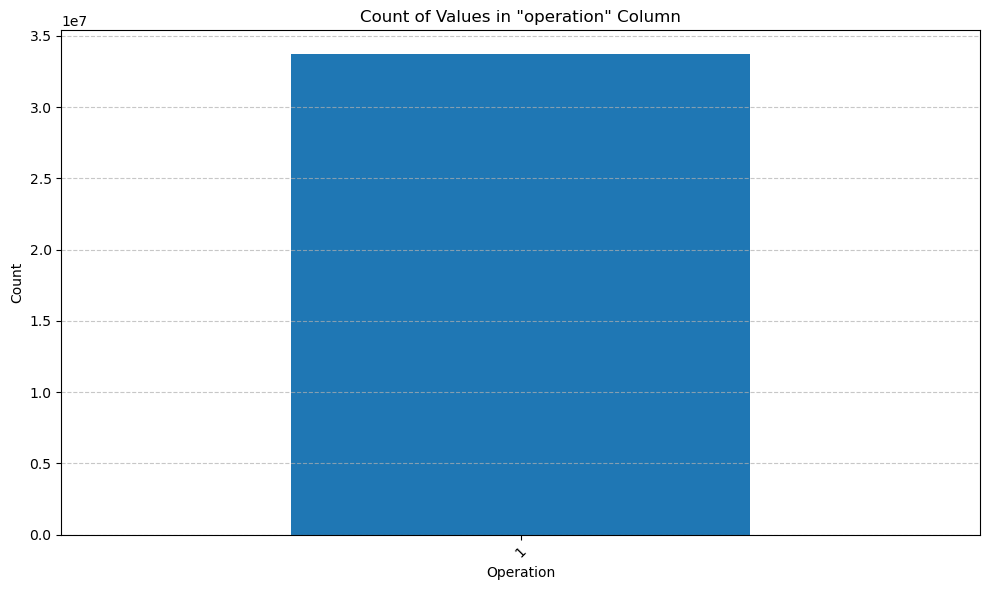

In [54]:
import matplotlib.pyplot as plt

# 값 개수 세기
value_counts = df['operation'].value_counts()

# 히스토그램 그리기
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar')
plt.title('Count of Values in "operation" Column')
plt.xlabel('Operation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
df = df.drop(columns = ['operation']) # 모든 행에 대해 1값을 가짐
df

,module(equipment),activePower,reactivePowerLagging,accumActiveEnergy,calculatedPower
localtime,,,,,
20241201000000,1(PM-3),2961.61,785.37,1955004,1.020542e+06
20241201000005,1(PM-3),3017.48,376.57,1955008,1.019521e+06
20241201000010,1(PM-3),2408.01,296.08,1955011,8.410871e+05
20241201000015,1(PM-3),3289.33,488.48,1955016,1.145165e+06
20241201000020,1(PM-3),3069.31,604.70,1955020,1.055080e+06
...,...,...,...,...,...
20250429235940,18(우측분전반2),2239.82,257.79,15438157,7.558268e+05
20250429235945,18(우측분전반2),2690.21,438.53,15438161,8.843992e+05
20250429235950,18(우측분전반2),2174.37,562.27,15438164,7.330272e+05


In [56]:
import os

# 저장할 경로
save_path = './datasets/preprocessed/rtu_data_preprocessed.parquet'

# Parquet 형식으로 저장
df.to_parquet(save_path)

In [57]:
df.columns

Index(['module(equipment)', 'activePower', 'reactivePowerLagging',
       'accumActiveEnergy', 'calculatedPower'],
      dtype='object')

5월 21일 수요일은 여기서 마무리 한다
-------
### 향후 TODO 정리

 남은 핵심 컬럼 간의 상관관계 분석 및 파악하기
activePower와 reactivePowerLagging, accumActiveEnergy, calculatedPower 간의 상관관계를 다시 한번 종합적으로 확인하기.
특히 reactivePowerLagging이 activePower 예측에 어떤 선형적 기여를 하는지 파악하기.
accumActiveEnergy는 누적 값임을 고려하여, activePower와의 상관관계 해석 시 차분(diff)의 필요성을 염두에 두기.
2. 핵심 특징 변수 최종 선정 및 accumActiveEnergy 전처리하기
activePower를 최종 목표 변수(y)로 확정하기.
calculatedPower를 강력한 특징 변수(X)로 포함하기. (이미 높은 상관관계가 확인됨)
reactivePowerLagging이 activePower와 유의미한 상관관계(예: 0.3 이상)를 보인다면, reactivePowerLagging도 특징 변수(X)로 포함하기. 상관관계가 매우 낮다면 제거를 고려하기.
accumActiveEnergy를 시간당 전력 소비량으로 변환하기. df['hourly_energy_consumption'] = df['accumActiveEnergy'].diff() 와 같이 계산하여 새로운 특징 변수로 추가하기. 이후 accumActiveEnergy 원본 컬럼은 제거하기.
module(equipment) 컬럼이 여러 고유 값을 가진다면, module(equipment)를 범주형 특징으로 처리하기. (예: 원-핫 인코딩 적용) 만약 고유 값이 하나라면(모든 데이터가 같은 장비라면) 해당 컬럼은 제거하기.
3. 시간 기반 특징 변수 생성하기
데이터프레임의 인덱스(localtime)를 활용하여 요일(Day of Week), 시간(Hour of Day), 월(Month) 등과 같은 시간 기반 파생 특징을 생성하기.
공휴일 정보가 있다면, 공휴일 여부를 나타내는 이진(Binary) 특징을 추가하기.
4. 데이터셋 분할하기 (Train-Test Split)
시계열 데이터의 특성을 고려하여 시간 순서대로 학습 데이터셋과 테스트 데이터셋을 분할하기. 미래 데이터를 사용하여 과거를 예측하는 정보 누출(data leakage)을 방지해야 한다. (예: 8:2 또는 7:3 비율로 과거 데이터를 학습에, 최신 데이터를 테스트에 사용)
5. 데이터 스케일링 적용하기
LSTM과 같은 신경망 모델을 고려하고 있으므로, 모든 수치형 특징 변수(X 데이터)에 대해 정규화(MinMaxScaler) 또는 표준화(StandardScaler)를 적용하기. 이는 모델 학습의 안정성과 성능 향상에 필수적이다.
Prophet이나 ARIMA 모델에서는 필수는 아니지만, 적용 시 모델의 안정성에 도움이 될 수 있다.
6. 모델 선택 및 학습 준비하기
ARIMA, Prophet, LSTM 중 어떤 모델을 사용할지 최종적으로 결정하고, 해당 모델이 요구하는 형태로 데이터를 준비하기.
ARIMA: 정상성 검정 및 필요시 차분 적용을 고려하기.
Prophet: 입력 데이터프레임이 ds(datetime)와 y(target) 컬럼을 가지도록 변환하기.
LSTM: 데이터를 (샘플 수, 타임스텝 수, 특징 수) 형태의 3D 시퀀스 데이터로 구성하기 (슬라이딩 윈도우 기법 활용).